<a href="https://colab.research.google.com/github/seungwoo900/cats-and-dogs-classification/blob/main/cats_dogs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path
import zipfile
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import numpy as np
import json

In [2]:
with open('kaggle.json', 'r') as f:
    kaggle_info = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle_info['username']
os.environ['KAGGLE_KEY'] = kaggle_info['key']

In [3]:
import kaggle

path = Path('/content')
path.mkdir(parents=True, exist_ok=True)

kaggle.api.dataset_download_files('shaunthesheep/microsoft-catsvsdogs-dataset', path=path, unzip=False)

dataset_zip = path / 'microsoft-catsvsdogs-dataset.zip'
with zipfile.ZipFile(dataset_zip, 'r') as z:
    z.extractall(path)

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset


In [ ]:
for root, _, files in os.walk('/content/PetImages'):
    for file in files:
        image_path = os.path.join(root, file)
        try:
            with Image.open(image_path) as img:
                img.verify()
        except (IOError, OSError, Image.DecompressionBombError):
            print(f"Deleting broken images: {image_path}")
            os.remove(image_path)

깨진 이미지 삭제: /content/PetImages/Cat/666.jpg
깨진 이미지 삭제: /content/PetImages/Cat/Thumbs.db
깨진 이미지 삭제: /content/PetImages/Dog/11702.jpg
깨진 이미지 삭제: /content/PetImages/Dog/Thumbs.db


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='/content/PetImages', transform=transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
dataset_size

24998

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0)
    return img

def get_class_label(preds):
    _, class_index = torch.max(preds, 1)
    print(class_index)
    return class_index.item()

def get_conv_layer(model, conv_layer_name):
    for name, layer in model.named_modules():
        if name == conv_layer_name:
            return layer
    return ValueError(f"Layer with name {conv_layer_name} not found")

def compute_gradcam(model, img_tensor, class_index, conv_layer_name='features.28'):
    conv_layer = get_conv_layer(model, conv_layer_name)

    activations = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
    hook = conv_layer.register_forward_hook(forward_hook)

    img_tensor.requires_grad_(True)
    preds = model(img_tensor)
    loss = preds[:, class_index]
    model.zero_grad()
    loss.backward()

    grads = img_tensor.grad.cpu().numpy()
    pooled_grads = np.mean(grads, axis=(0, 2, 3))

    hook.remove()
    activations = activations.detach().cpu().numpy()[0]

    for i in range(pooled_grads.shape[0]):
        activations[i, ...] *= pooled_grads[i]

    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

def img_check(model, img_path='/content/PetImages/Cat/10000.jpg'):
  model.eval()
  img_tensor = preprocess_image(img_path)
  img_tensor = img_tensor.to(device)

  with torch.no_grad():
      preds = model(img_tensor)
  class_index = get_class_label(preds)
  print(f"Predicted Class Index: {class_index}")

  heatmap = compute_gradcam(model, img_tensor, class_index)
  output_img = overlay_heatmap(img_path, heatmap)

  cv2.imwrite(f'output_image.jpg', output_img)
  out = cv2.imread(f'output_image.jpg')
  cv2_imshow(out)

### Plain VGG16 Grad-CAM

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
# print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze all layers except the classifier
for param in model.parameters():
  param.requires_grad = False

for param in model.classifier.parameters():
  param.requires_grad = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

tensor([1], device='cuda:0')
Predicted Class Index: 1


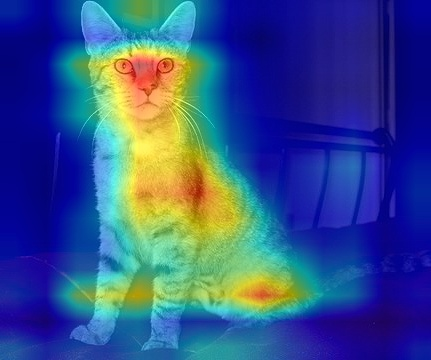

In [ ]:
img_check(model)

tensor([1], device='cuda:0')
Predicted Class Index: 1


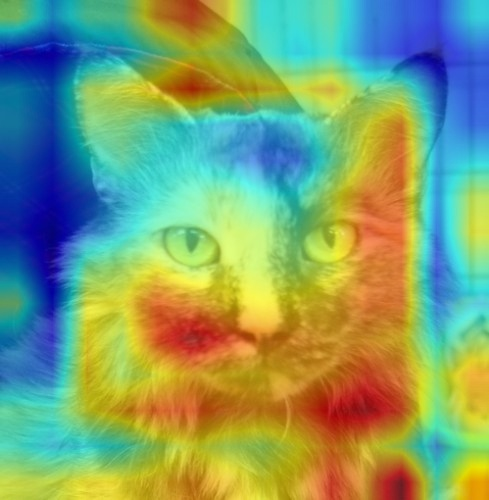

In [ ]:
img_check(model, img_path='/content/PetImages/Cat/10.jpg')

### Train the model with all layers unfreezed

In [ ]:
new_model = models.vgg16(pretrained=True)
new_model.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# Unfreeze all layers
for param in new_model.parameters():
  param.requires_grad = True

for param in new_model.classifier.parameters():
  param.requires_grad = True

new_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    new_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    _, predicted = outputs.max(1)
    correct += predicted.eq(labels).sum().item()
    total += labels.size(0)

    print(f'Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10], Loss: 0.0442, Accuracy: 100.00%
Epoch [2/10], Loss: 0.0149, Accuracy: 100.00%
Epoch [3/10], Loss: 0.0075, Accuracy: 100.00%
Epoch [4/10], Loss: 0.0050, Accuracy: 100.00%
Epoch [5/10], Loss: 0.0029, Accuracy: 100.00%
Epoch [6/10], Loss: 0.0012, Accuracy: 100.00%
Epoch [7/10], Loss: 0.0011, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0013, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0006, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0006, Accuracy: 100.00%


tensor([0], device='cuda:0')
Predicted Class Index: 0


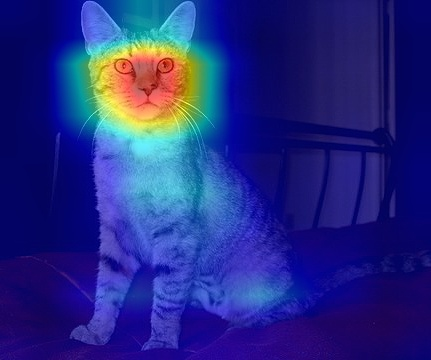

In [ ]:
img_check(new_model)

tensor([0], device='cuda:0')
Predicted Class Index: 0


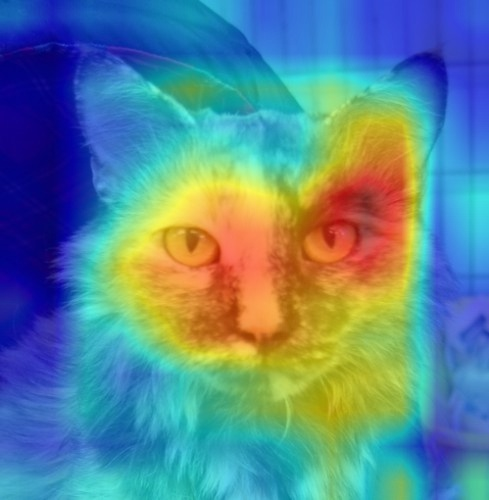

In [ ]:
img_check(new_model, img_path='/content/PetImages/Cat/10.jpg')

fatal: destination path 'cats-and-dogs-classification' already exists and is not an empty directory.
